In [1]:
!pip install torch torchvision captum

In [2]:
!gdown --fuzzy -O persian-traffic-sign-dataset-ptsd.zip https://drive.google.com/file/d/1pRiakCLfvu0UQ5FclaJHjTuVIXuk-VDx/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=1pRiakCLfvu0UQ5FclaJHjTuVIXuk-VDx
To: /content/persian-traffic-sign-dataset-ptsd.zip
 13% 73.9M/570M [00:00<00:05, 93.7MB/s]Traceback (most recent call last):
  File "/usr/local/bin/gdown", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/gdown/cli.py", line 151, in main
    filename = download(
  File "/usr/local/lib/python3.10/dist-packages/gdown/download.py", line 274, in download
    for chunk in res.iter_content(chunk_size=CHUNK_SIZE):
  File "/usr/local/lib/python3.10/dist-packages/requests/models.py", line 816, in generate
    yield from self.raw.stream(chunk_size, decode_content=True)
  File "/usr/local/lib/python3.10/dist-packages/urllib3/response.py", line 936, in stream
    data = self.read(amt=amt, decode_content=decode_content)
  File "/usr/local/lib/python3.10/dist-packages/urllib3/response.py", line 879, in read
    data = self._raw_read(amt)
  File "/usr/local/lib/python3.10/dist

In [3]:
!unzip persian-traffic-sign-dataset-ptsd.zip

Archive:  persian-traffic-sign-dataset-ptsd.zip
replace PTSD.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [1]:
import os
import cv2
import random
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

from PIL import Image
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from captum.attr import LayerGradCam
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [2]:
# List of folders representing different classes or labels
select_folder_list = ["0_Compulsory Keep BothSide",
                      "1_Compulsory Keep Left",
                      "2_Compulsory Keep Right",
                      "3_Cycle crossing",
                      "4_Danger",
                      "5_Give Way",
                      "6_Hump",
                      "7_Left Bend",
                      "8_Left Margin",
                      "9_Left Turn Prohibited"
                      ]

# Mapping from folder names to numerical indices
class_to_idx = {"Compulsory Keep BothSide": 0,
                "Compulsory Keep Left": 1,
                "Compulsory Keep Right": 2,
                "Cycle crossing": 3,
                "Danger": 4,
                "Give Way": 5,
                "Hump": 6,
                "Left Bend": 7,
                "Left Margin":8,
                "Left Turn Prohibited": 9
                }

# Mapping from numerical indices to folder names
idx_to_class = {0 : "Compulsory Keep BothSide",
                1 : "Compulsory Keep Left",
                2 : "Compulsory Keep Right",
                3 : "Cycle crossing",
                4 : "Danger",
                5 : "Give Way",
                6 : "Hump",
                7 : "Left Bend",
                8 : "Left Margin",
                9 : "Left Turn Prohibited"
                }

In [3]:
def label_select(folder_name):
    # Mapping from folder names with numerical prefixes to more human-readable labels
    folder_mapping = {
        "0_Compulsory Keep BothSide": "Compulsory Keep BothSide",
        "1_Compulsory Keep Left": "Compulsory Keep Left",
        "2_Compulsory Keep Right": "Compulsory Keep Right",
        "3_Cycle crossing": "Cycle crossing",
        "4_Danger": "Danger",
        "5_Give Way": "Give Way",
        "6_Hump": "Hump",
        "7_Left Bend": "Left Bend",
        "8_Left Margin": "Left Margin",
        "9_Left Turn Prohibited": "Left Turn Prohibited"
    }
    return folder_mapping.get(folder_name, folder_name)


 # Create a list of tuples containing image paths and their corresponding labels
def create_image_label_list(root_folder, num_folders=None):
    image_label_list = []
    folders = os.listdir(root_folder)
    for folder_name in select_folder_list:
        folder_path = os.path.join(root_folder, folder_name)
        if os.path.isdir(folder_path):
            label = label_select(folder_name)
            images = os.listdir(folder_path)
            for image_name in images:
                image_path = os.path.join(folder_path, image_name)
                image_label_list.append((image_path, label))

    return image_label_list

# Display images with their corresponding labels in a grid layout
def display_images(image_label_list, num_images=10):
    num_rows = 2
    num_cols = 5
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))
    for i in range(min(num_images, len(image_label_list))):
        row = i // num_cols
        col = i % num_cols
        image_path, label = image_label_list[i]
        img = mpimg.imread(image_path)
        axes[row, col].imshow(img)
        axes[row, col].set_title(f"Label: {label}")
        axes[row, col].axis('off')
    plt.show()

# Display images with their corresponding labels
def show_image_with_label(images, label):
    # images = img.cpu().numpy()
    for i in range(images.shape[0]):
        plt.imshow(images[i].transpose((1, 2, 0)))  # Transpose to (height, width, channels)
        plt.axis('off')
        plt.title(f"Label: {labels[i].item()}")
        plt.show()

In [4]:
# Assuming 'testset_CSV.csv' is a CSV file containing a 'species' column
testset_CSV = 'testset_CSV.csv'

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(testset_CSV)

# Filter rows in the DataFrame based on the 'species' column
# Keep only the rows where 'species' is in the specified list
filtered_rows = df[df['species'].isin(['Compulsory Keep Left', 'Compulsory Keep Right', 'Cycle crossing', 'Danger', 'Give Way', 'Hump', 'Left Bend', 'Left Margin', 'Left Turn Prohibited'])]

In [5]:
# Define the path to the folder containing test images
test_image_folder = '/content/PTSD_Recognition/PTSD_Recognition/test'

# Create an empty list to store tuples of image paths and labels
image_and_label_test_list = []

# Iterate over the filtered rows of the DataFrame
for index, row in filtered_rows.iterrows():
    # Generate the full path to the test image using the 'file' column
    image_path = os.path.join(test_image_folder, ("PTSD_"+row['file'].lower()))
    # Append a tuple of the image path and its corresponding 'species' label to the list
    image_and_label_test_list.append((image_path, row['species']))

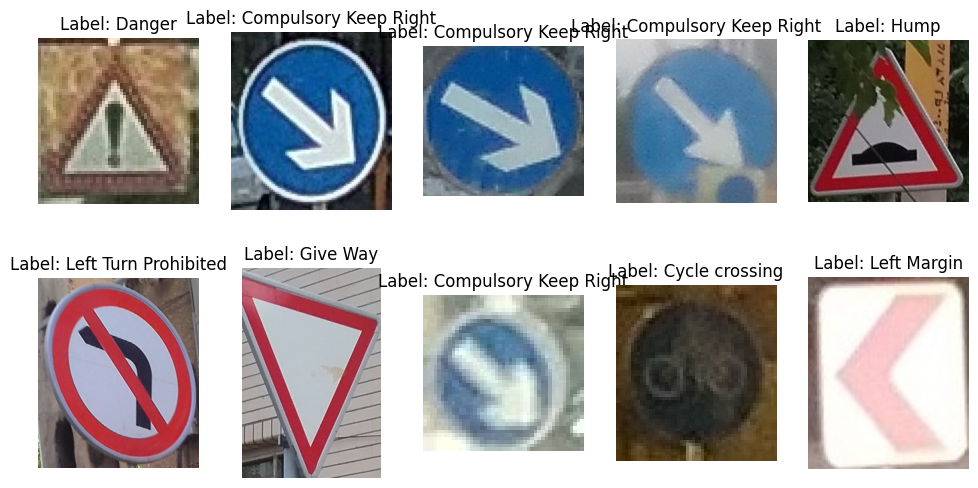

In [6]:
# Define the path to the training dataset folder
dataset_folder = '/content/PTSD_Recognition/PTSD_Recognition/train'

# Specify the number of folders (classes) to consider (assuming 10 in this case)
num_folders = 10

# Create a list of image-label pairs using the create_image_label_list function
image_and_label_list = create_image_label_list(dataset_folder, num_folders=num_folders)

# Shuffle the list of image-label pairs randomly
random.shuffle(image_and_label_list)

# Display a subset of images with their corresponding labels using the display_images function
# Here, num_images=10 specifies the number of images to display
display_images(image_and_label_list, num_images=10)

In [7]:
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, image_and_label_list, class_to_idx, transform=None):
        self.image_and_label_list = image_and_label_list
        self.transform = transform
        self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.image_and_label_list)

    def __getitem__(self, idx):
        img_path, label = self.image_and_label_list[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        class_index = self.class_to_idx[label]
        return image, class_index

In [8]:
# Set data transformation for training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    # Normalize
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Set data transformation for testing
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    # transforms.RandomGrayscale(p=0.1),
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    # Normalize
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create an instance of the custom dataset for training
dataset = CustomDataset(image_and_label_list, class_to_idx, transform=transform)


# Split the dataset into training and validation sets
validation_split = 0.2
dataset_size = len(image_and_label_list)
validation_size = int(validation_split * dataset_size)
train_size = dataset_size - validation_size
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])

# Create data loaders for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [9]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        # Batch Normalize
        # Batch normalization for the first convolutional layer
        self.BatchNorm1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        # Max pooling layer after the first convolutional layer
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        # Batch Normalize
        # Batch normalization for the second convolutional layer
        self.BatchNorm2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        # Max pooling layer after the second convolutional layer
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully connected layer
        self.fc1 = nn.Linear(32 * 3136, num_classes)
        # Initialize weights using Xavier initialization
        self.initialize_weights()

    # Initialize weights using Xavier initialization for convolutional and linear layers
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    init.zeros_(m.bias)

    # Forward pass through the network
    def forward(self, x):
        x = self.conv1(x)
        x = self.BatchNorm1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.BatchNorm2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

Epoch [1/100], Loss: 0.005318539682775736, Validation Loss: 2.863855585542128, Accuracy: 0.6794717887154862
Epoch [2/100], Loss: 0.0010055014863610268, Validation Loss: 0.5545157856756339, Accuracy: 0.8331332533013205
Epoch [3/100], Loss: 0.039264462888240814, Validation Loss: 0.42430961270023276, Accuracy: 0.8619447779111644
Epoch [4/100], Loss: 0.38993868231773376, Validation Loss: 0.4366264139060621, Accuracy: 0.879951980792317
Epoch [5/100], Loss: 0.0007871866691857576, Validation Loss: 0.4194326603319496, Accuracy: 0.8631452581032413
Epoch [6/100], Loss: 0.009088574908673763, Validation Loss: 0.38725850368953413, Accuracy: 0.8727490996398559
Epoch [7/100], Loss: 0.0011845960980281234, Validation Loss: 0.3018727605532924, Accuracy: 0.9003601440576231
Epoch [8/100], Loss: 0.0006112375995144248, Validation Loss: 0.2971415196640279, Accuracy: 0.9063625450180072
Epoch [9/100], Loss: 0.000376034586224705, Validation Loss: 0.26686454633535406, Accuracy: 0.9207683073229291
Epoch [10/100],

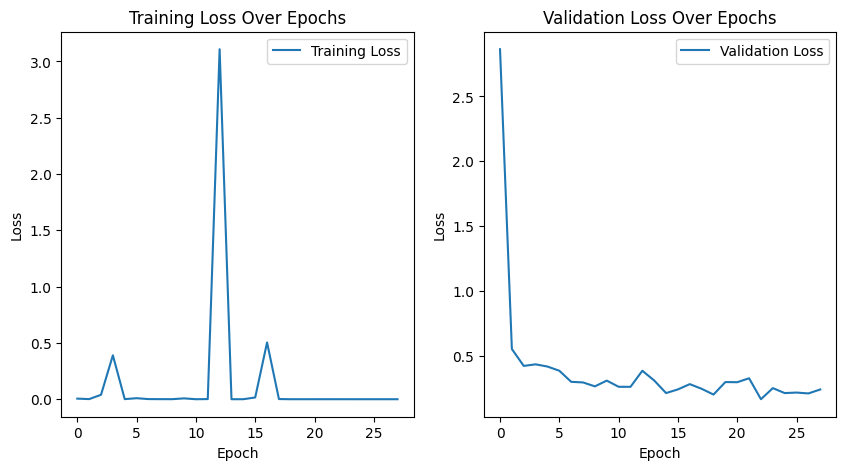

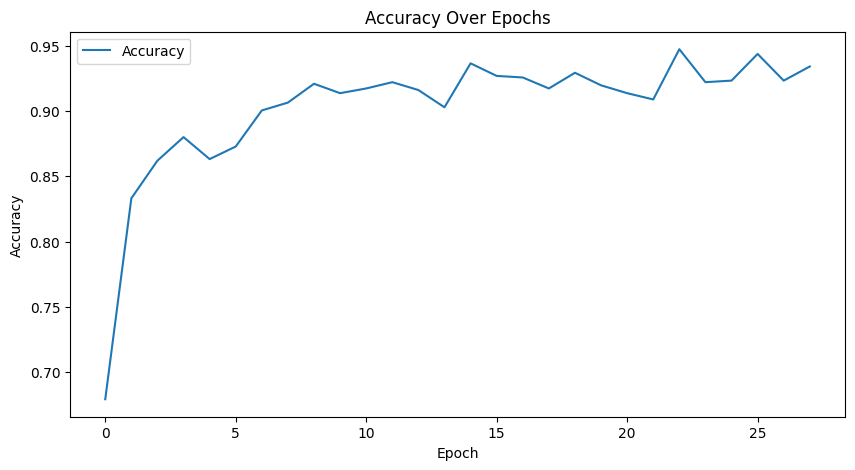

In [10]:
# Lists to store training information for plotting
train_losses = []
validation_losses = []
accuracies = []

# Check if GPU (cuda) is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = CNNModel(num_classes=10).to(device)

# Define loss function (CrossEntropyLoss) and optimizer (Adam)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the number of training epochs, patience for early stopping, and initialize variables for early stopping
num_epochs = 100
patience = 5
best_val_loss = float('inf')
counter = 0

# Training loop
for epoch in range(num_epochs):
    # Training phase
    for img, lab in train_dataloader:
        images, labels = img.to(device), lab.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        validation_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for images, labels in validation_dataloader:
            images, labels = images.to(device), labels.to(device)
            # show_image_with_label(images, labels)
            outputs = model(images)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            # Record predictions for later analysis
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        # Calculate Validation accuracy
        average_validation_loss = validation_loss / len(validation_dataloader)
        accuracy = correct_predictions / total_samples

    # Print and check for early stopping
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}, Validation Loss: {average_validation_loss}, Accuracy: {accuracy}")

    # Append information for plotting
    train_losses.append(loss.item())
    validation_losses.append(average_validation_loss)
    accuracies.append(accuracy)

    # Check for early stopping
    if average_validation_loss < best_val_loss:
        best_val_loss = average_validation_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping after {epoch} epochs.')
            break

# Plotting the results
plt.figure(figsize=(10, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot Validation Loss
plt.subplot(1, 2, 2)
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.show()

In [11]:
# Create an instance of the custom dataset for testing
test_dataset = CustomDataset(image_and_label_test_list, class_to_idx, transform=transform_test)
# Create a data loader for the test set
test_dataloader = DataLoader(test_dataset, shuffle=True)

In [12]:
# List to store predictions for later analysis
predicted_list = []

# Test the model on the test set
model.eval()

with torch.no_grad():
    test_correct_predictions = 0
    test_total_samples = 0
    all_predicted = []
    all_labels = []

    # Iterate over the test dataset
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        # Record predictions for later analysis
        _, predicted = torch.max(outputs, 1)
        predicted_list.append((images, predicted))
        # Calculate test accuracy
        test_correct_predictions += (predicted == labels).sum().item()
        test_total_samples += labels.size(0)
        # Collect predicted and true labels for further analysis
        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Calculate test accuracy
    test_accuracy = test_correct_predictions / test_total_samples
    print(f"Test Accuracy: {test_accuracy}")

    # Calculate precision, recall, and confusion matrix
    precision = precision_score(all_labels, all_predicted, average='weighted')
    recall = recall_score(all_labels, all_predicted, average='weighted')
    confusion_mat = confusion_matrix(all_labels, all_predicted)

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print("Confusion Matrix:")
    print(confusion_mat)

Test Accuracy: 0.839563862928349
Precision: 0.893315791739533
Recall: 0.839563862928349
Confusion Matrix:
[[ 0  0  0  0  0  0  0  0  0  0]
 [ 5 62  0  8  9  0  0  0  0  0]
 [ 2  3 75 40  5  0  0  0  0  0]
 [ 2  0  0 59  0  0  0  0  1  0]
 [ 0  0  0  0 62  0  6  0  0  1]
 [ 0  0  0  0  0 85  3  0  2  0]
 [ 0  0  0  0 11  0 68  0  0  0]
 [ 0  0  0  0  2  0  0 16  0  2]
 [ 0  0  0  0  0  0  0  0 72  0]
 [ 0  0  0  0  0  0  1  0  0 40]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


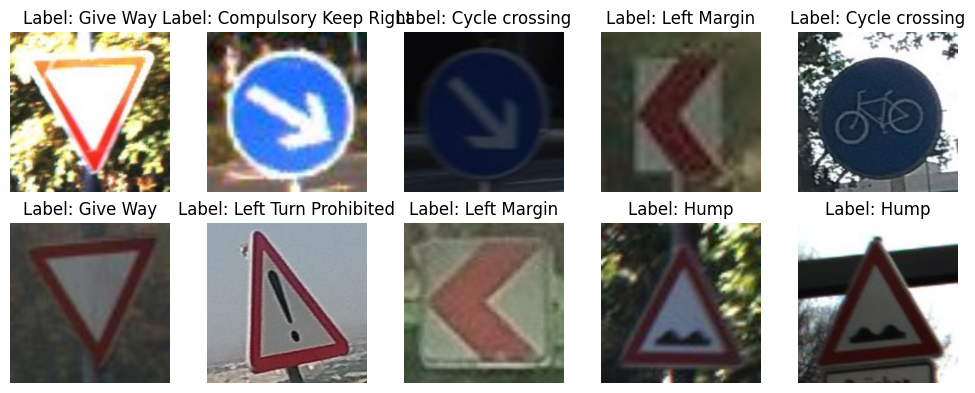

In [13]:
# Shuffle the predicted list for random display
random.shuffle(predicted_list)

# Mean and standard deviation values for image normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Create a 2x5 subplot grid for image display
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

# Iterate through the subplot grid
for i in range(2):
    for j in range(5):
        index = i * 5 + j
        img, predic = predicted_list[index]
        image = img.cpu().numpy()  # Move the tensor to CPU and convert to NumPy array
        predicted = predic.item()
        # Transpose the image to (height, width, channels, batch) format
        image = np.transpose(image, (2, 3, 1, 0))  # Assuming the shape is (1, 3, 224, 224)
        image = image.squeeze()  # Remove singleton dimensions

        # Assuming the image has 3 channels (RGB)
        # Denormalize the image by reversing the normalization
        for k in range(3):
            image[:, :, k] = image[:, :, k] * std[k] + mean[k]

        # Clip the pixel values to be within the valid range [0, 1]
        image = np.clip(image, 0, 1)

        # Convert the NumPy array back to a PIL Image
        img_pil = Image.fromarray((image * 255).astype(np.uint8))

        # Display the image along with the predicted label as the title
        axes[i, j].imshow(img_pil)
        axes[i, j].set_title(f"Label: {idx_to_class[predicted]}")
        axes[i, j].axis('off')

# Display the plot
plt.tight_layout()
plt.show()

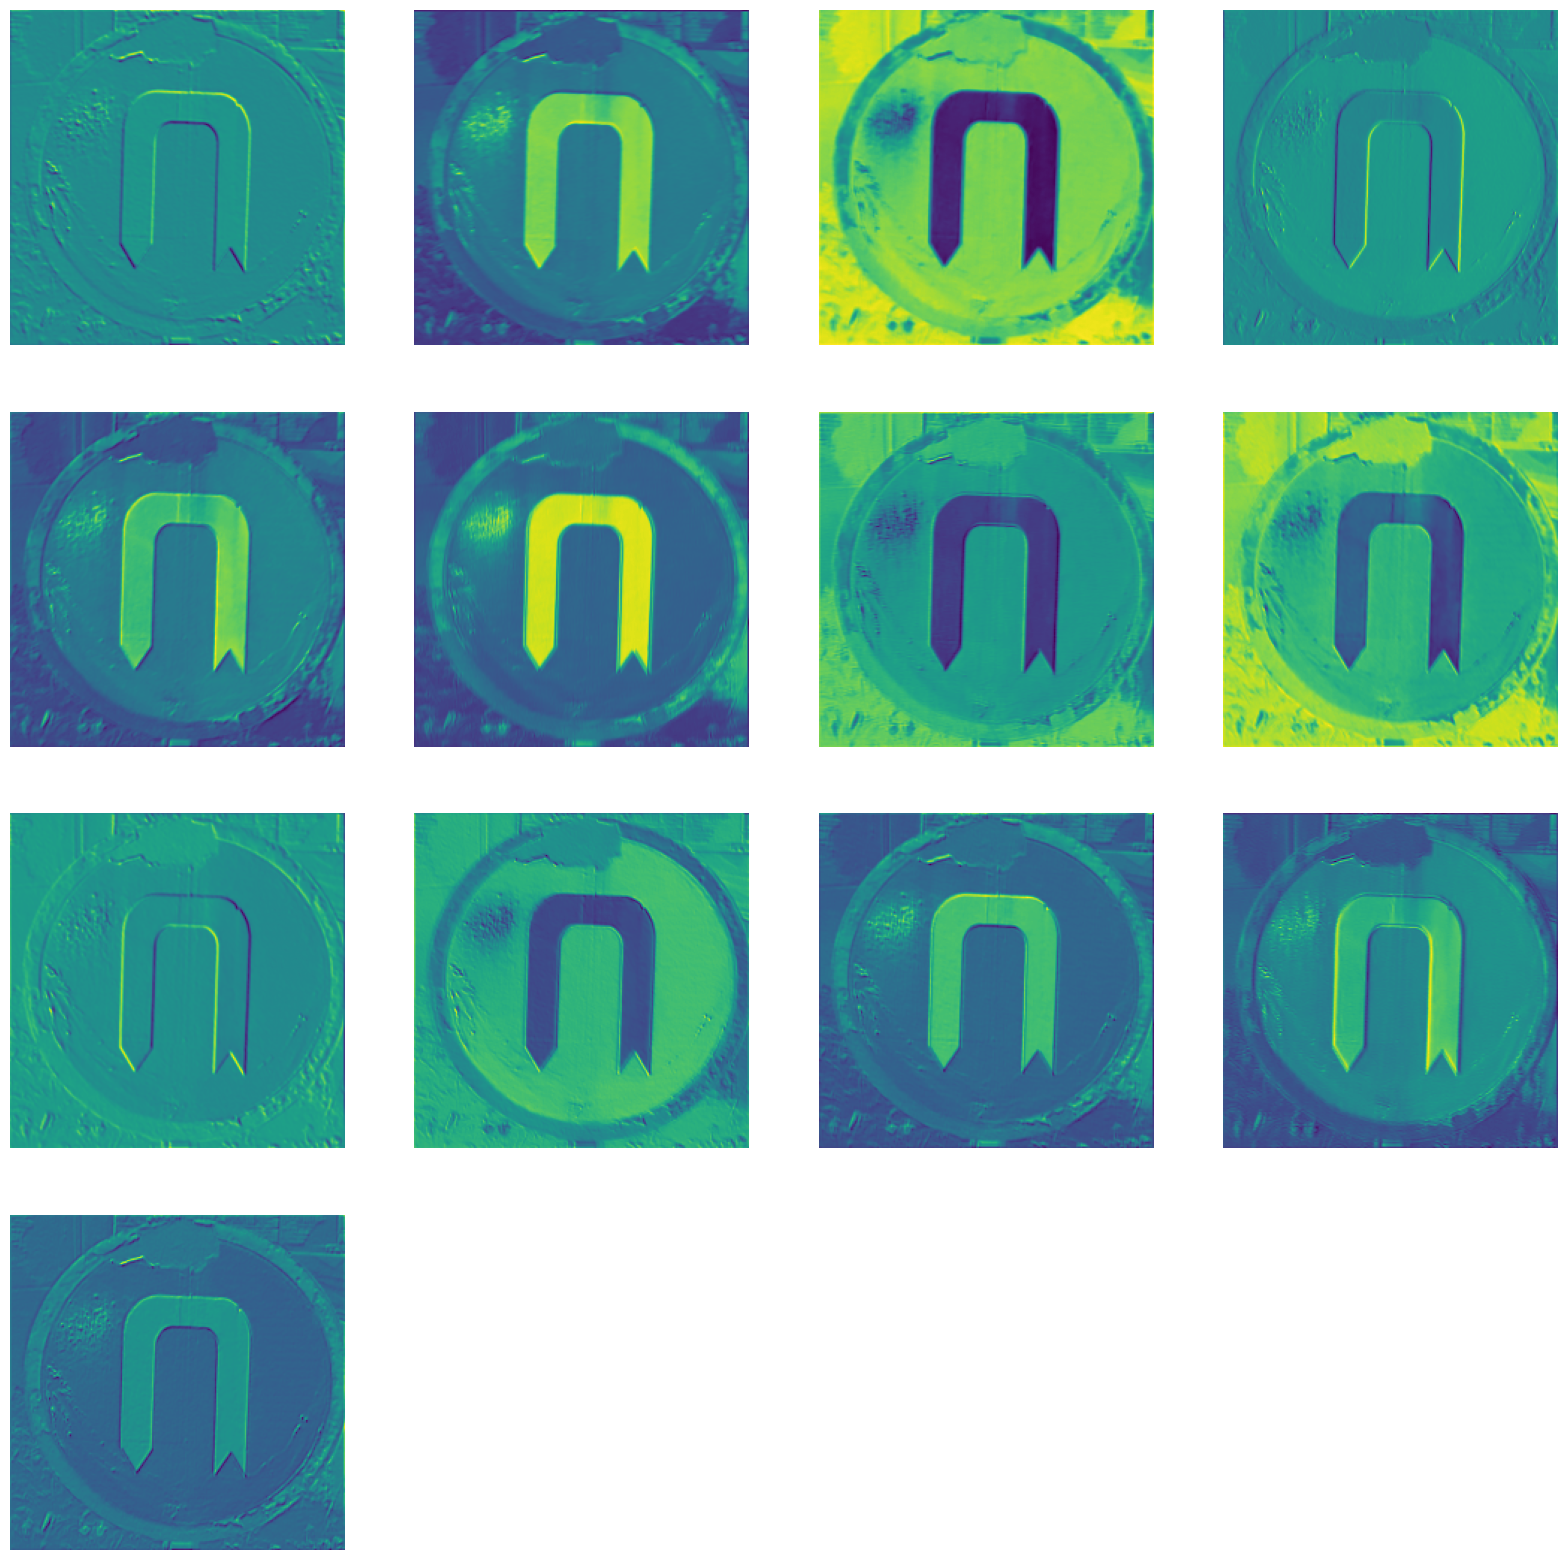

In [22]:
# List to store the number of activations for each layer
num_activations = []

# Dictionary to store activation values
activation = {}

# Load a sample image
image_path = "/content/PTSD_Recognition/PTSD_Recognition/test/PTSD_00105.jpg"
img = Image.open(image_path)

# Define a transform to preprocess the image
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Preprocess the image
img_tensor = preprocess(img)
image = img_tensor.unsqueeze(0)

# Move the model and image to the specified device (CPU or GPU)
model = model.to(device)
image = image.to(device)
model.eval()

# Choose the target layer for visualization
target_layer = model.conv1

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


# Register a forward hook to get intermediate layer activations
hook = target_layer.register_forward_hook(get_activation('target_layer'))

# Forward pass
with torch.no_grad():
    model(image)

# Unregister the hook
hook.remove()

# Visualize the activations
activations = activation['target_layer'][0].cpu().numpy()
num_activations = activations.shape[0]

# Plot all activation maps in an 8x5 grid
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
for i in range(4):
    for j in range(4):
        index = i * 5 + j
        if index < num_activations:
            axs[i, j].imshow(activations[index], cmap='viridis')
            axs[i, j].axis('off')
        else:
            axs[i, j].axis('off')

plt.show()

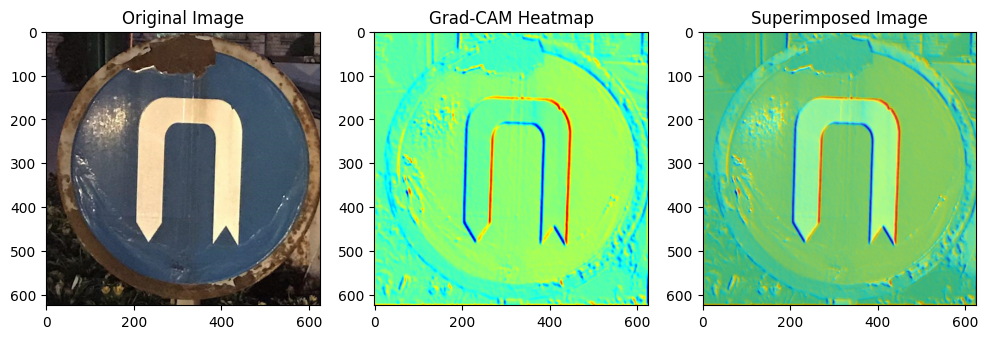

In [23]:
# Load a sample image and preprocess it
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)  # Use the mean and std you defined earlier
])

imag = Image.open(image_path).convert('RGB')
input_image = transform(imag).unsqueeze(0)

# Convert the input image to a tensor and move it to the device
input_image = input_image.to(device)

# Create a Grad-CAM attribute layer for the last convolutional layer
grad_cam = LayerGradCam(model, model.conv1)

# Forward pass to get the predicted class scores
output = model(input_image)

# Get the predicted class index
predicted_class = torch.argmax(output)

# Compute the Grad-CAM attribution for the predicted class
attribution = grad_cam.attribute(input_image, target=predicted_class)

# Convert the attribution tensor to a numpy array
# heatmap = attribution.squeeze().cpu().numpy()
heatmap = attribution.squeeze().detach().cpu().numpy()

# Resize the heatmap to match the input image size
heatmap = cv2.resize(heatmap, (imag.size[0], imag.size[1]))

# Normalize the heatmap values to be in the range [0, 1]
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

# Apply colormap for visualization
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

# Superimpose the heatmap on the original image
superimposed_img = heatmap_colored * 0.7 + np.array(imag) * 0.3
superimposed_img = superimposed_img.astype(np.uint8)

# Display the original image, heatmap, and superimposed image
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(imag)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(heatmap_colored)
plt.title('Grad-CAM Heatmap')

plt.subplot(1, 3, 3)
plt.imshow(superimposed_img)
plt.title('Superimposed Image')

plt.show()

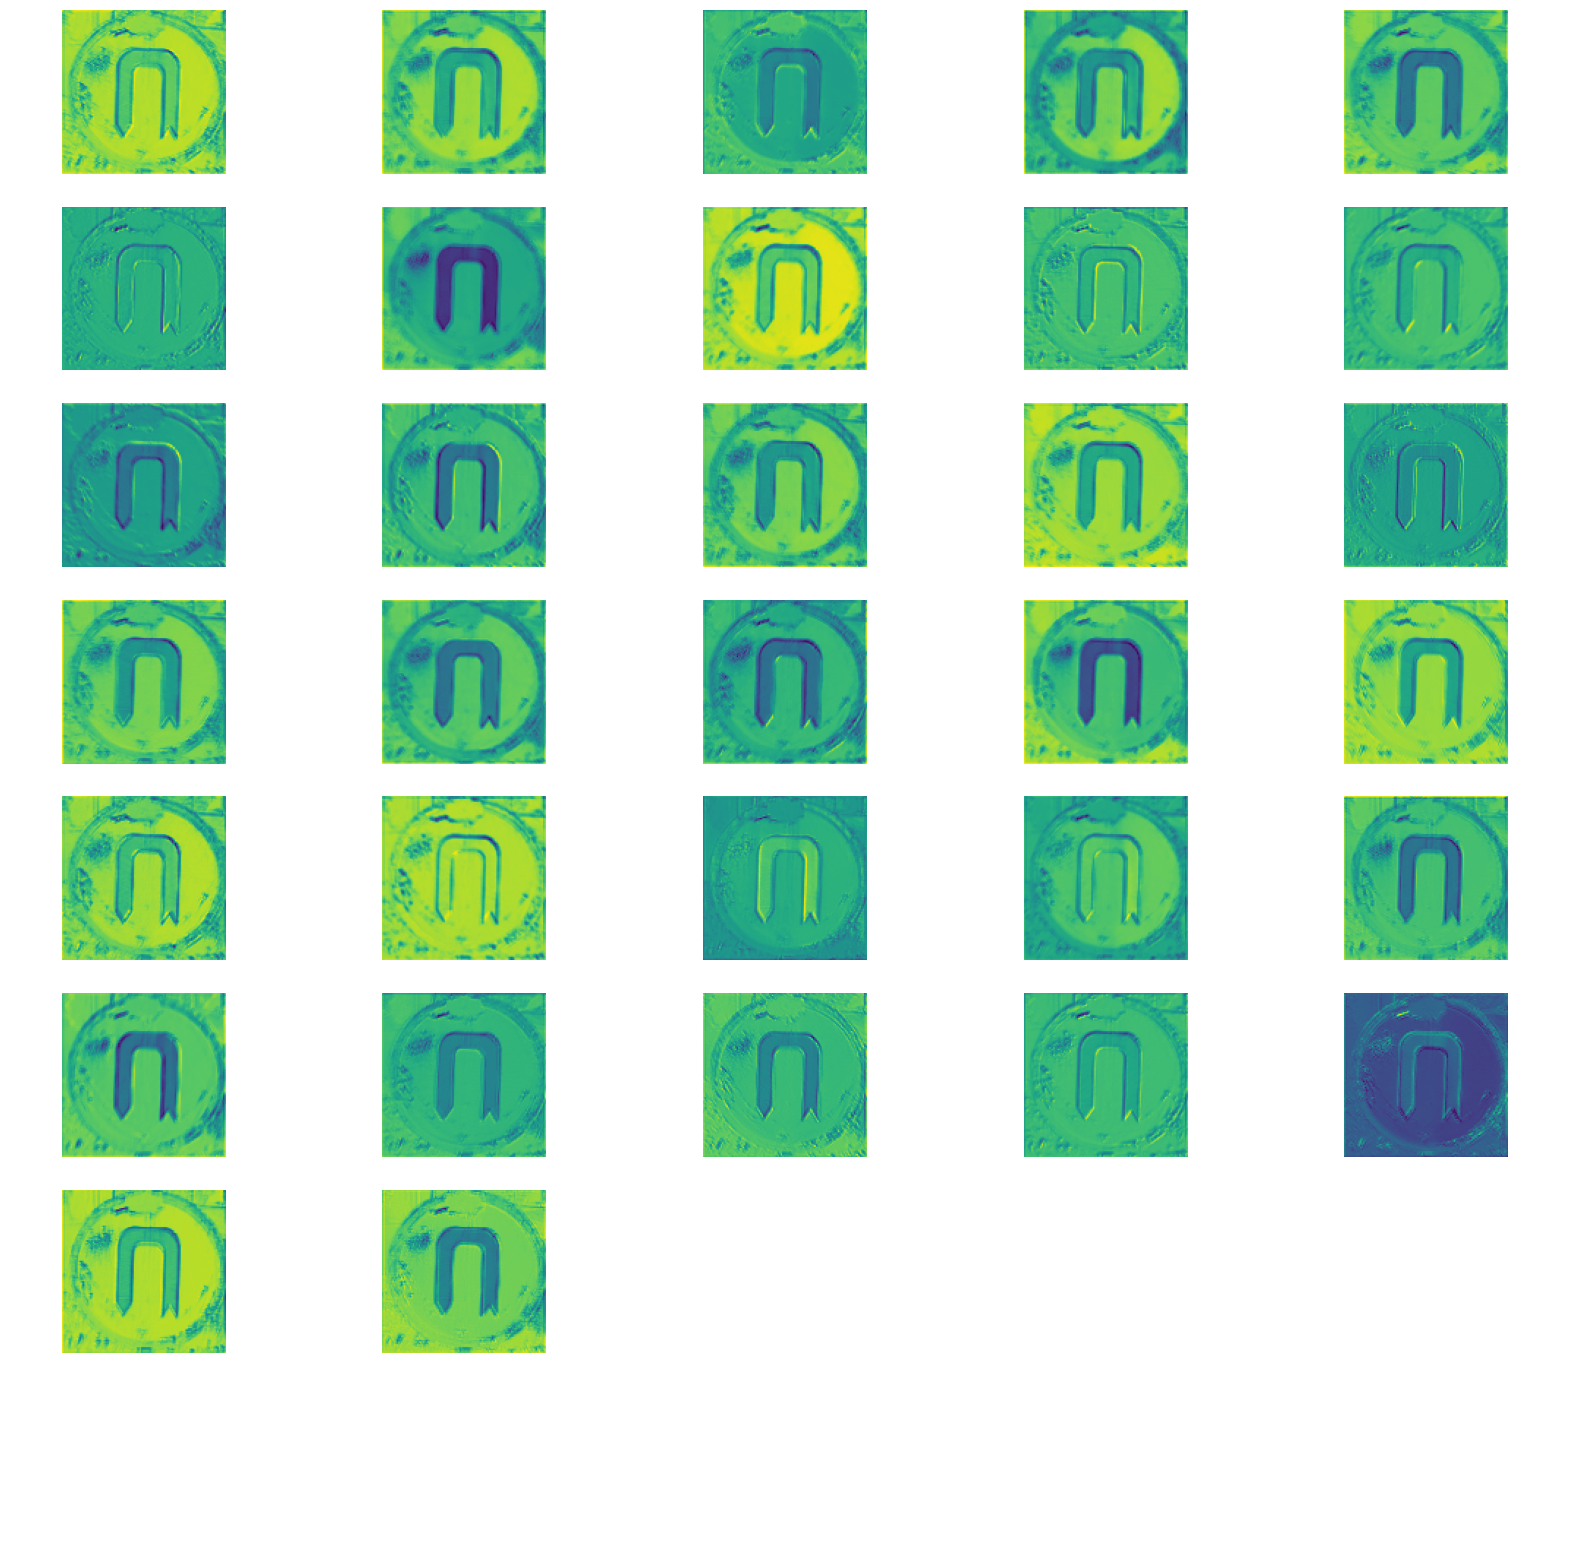

In [24]:
num_activations = []
# Choose the target layer for visualization
target_layer = model.conv2

# Register a forward hook to get intermediate layer activations
hook = target_layer.register_forward_hook(get_activation('target_layer'))

# Forward pass
with torch.no_grad():
    model(image)

# Unregister the hook
hook.remove()

# Visualize the activations
activations = activation['target_layer'][0].cpu().numpy()
num_activations = activations.shape[0]

fig, axs = plt.subplots(8, 5, figsize=(20, 20))
for i in range(8):
    for j in range(5):
        index = i * 5 + j
        if index < num_activations:
            axs[i, j].imshow(activations[index], cmap='viridis')
            axs[i, j].axis('off')
        else:
            axs[i, j].axis('off')

plt.show()

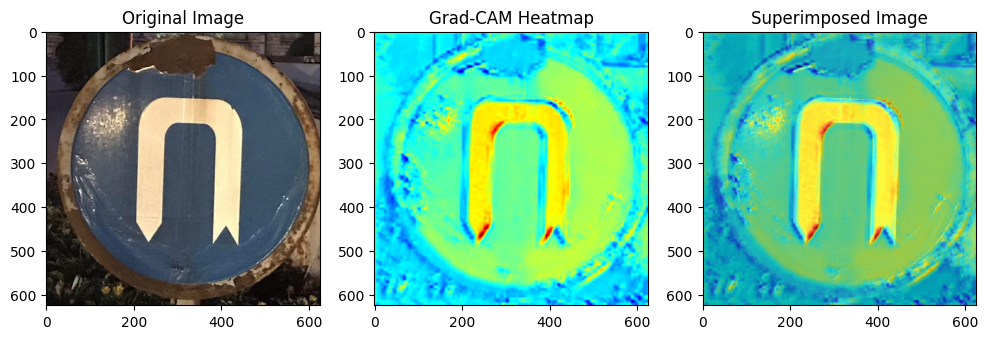

In [25]:
# Load a sample image and preprocess it
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)  # Use the mean and std you defined earlier
])

image = Image.open(image_path).convert('RGB')
input_image = transform(image).unsqueeze(0)

# Convert the input image to a tensor and move it to the device
input_image = input_image.to(device)

# Create a Grad-CAM attribute layer for the last convolutional layer
grad_cam = LayerGradCam(model, model.conv2)

# Forward pass to get the predicted class scores
output = model(input_image)

# Get the predicted class index
predicted_class = torch.argmax(output)

# Compute the Grad-CAM attribution for the predicted class
attribution = grad_cam.attribute(input_image, target=predicted_class)

# Convert the attribution tensor to a numpy array
# heatmap = attribution.squeeze().cpu().numpy()
heatmap = attribution.squeeze().detach().cpu().numpy()

# Resize the heatmap to match the input image size
heatmap = cv2.resize(heatmap, (image.size[0], image.size[1]))

# Normalize the heatmap values to be in the range [0, 1]
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

# Apply colormap for visualization
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

# Superimpose the heatmap on the original image
superimposed_img = heatmap_colored * 0.7 + np.array(image) * 0.3
superimposed_img = superimposed_img.astype(np.uint8)

# Display the original image, heatmap, and superimposed image
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(heatmap_colored)
plt.title('Grad-CAM Heatmap')

plt.subplot(1, 3, 3)
plt.imshow(superimposed_img)
plt.title('Superimposed Image')

plt.show()